# Ternary stochastic neuron

## goal of the notebook
- To develop a model of ternary stochastic neuron in `JAX`
- Show the transitions between the states as a function of the noise-free input.
- Subject the model to gaussian additive noise.
- One of the later aims could also be to characterize the gradient. Comparing the empirical and the calculated values.



In [1]:
import jax
import jax.numpy as jnp
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
# import torch
# import torchvision.transforms as transforms
# from torchvision import datasets
# from torch.utils.data import DataLoader


from sklearn.datasets import make_moons

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

In [2]:
from tqdm.notebook import tqdm

In [3]:
DATA_PATH = f"/Users/vikrantjaltare/OneDrive - UC San Diego/Datasets/"
FIGURES_PATH = f"/Users/vikrantjaltare/OneDrive - UC San Diego/Figures/onr_figures/"

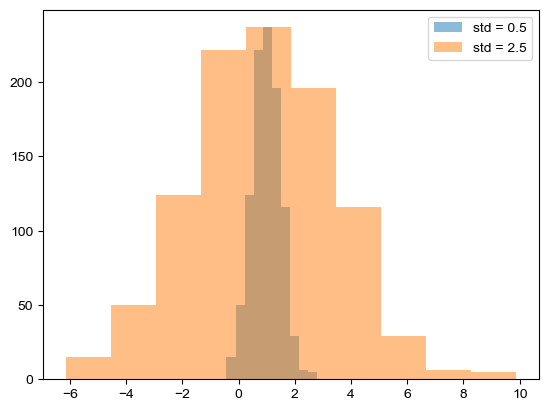

In [4]:
## Try: generating random numbers
key1 = jax.random.key(1)
mu1 = 1.0
std1 = 0.5
zeta_arr1 = mu1 + jax.random.normal(key1, (1000,))*std1
zeta_arr2 = mu1 + jax.random.normal(key1, (1000,))*std1*5
plt.hist(zeta_arr1, alpha =.5, label = f"std = {std1}")
plt.hist(zeta_arr2, alpha =.5, label=f"std = {std1*5}")

plt.legend()


In [5]:
## create a neuron model
@jax.jit
def state_function(x, threshold):
    """
    Implements ternary state updates.
    For threshold is a two-element array
    """

    theta1, theta2 = threshold

    state = jax.lax.cond(
        x < theta1,
        lambda _ : -1,
        lambda _ : jax.lax.cond(
            x > theta2,
            lambda _: 1,
            lambda _: 0,
            None),
        None )
    
    return state


@jax.jit
def activation(W, b, x):
    return jnp.dot(W, x) + b

@jax.jit
def generate_keys(init_key = 101, num_keys = 1000):
    key = jax.random.key(init_key)
    return jax.random.split(key, num = num_keys)

@jax.jit
def generate_gaussian_noise(key, mean, std, size):
    """
    Generate random samples from a Gaussian distribution of a given size
    """
    return mean + jax.random.normal(key, (size,)) * std

@jax.jit
def gaussian_erf(x, mu, sigma):
    """
    Gaussian error function. 
    To compute survivor function simply use 1 - erf
    """
    return 0.5 * (1 + jax.scipy.special.erf((x - mu) / (sigma * jnp.sqrt(2))))

@jax.jit
def expected_state(y_tilde, threshold, std):
    """"
    Calculate the expected state.
    Assume threshold to be a two element array
    """

    # unpack the thresholds
    theta1, theta2 = threshold

    # calculate the expected state
    E = (1/(jnp.sqrt(2 * jnp.pi) * std)) * ((1 - gaussian_erf(x = theta2 - y_tilde, mu = 0, sigma = std)) - gaussian_erf(x = theta1 - y_tilde, mu = 0, sigma = std)) # jnp.maximum(0, y_tilde)#
    return E





# Defining the architecture

In [6]:
## Helper function to initialize the weights 
def random_layer_params(input_size, output_size, key):
    """
    Initialize the weights and biases for a single layer
    """
    scale = jnp.sqrt(2/(input_size + output_size))
    w_key, b_key = jax.random.split(key)
    W = jax.random.normal(w_key, (output_size, input_size)) * scale
    b = jax.random.normal(b_key, (output_size, )) * scale

    return W, b

## Initialize all the layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    """
    Initialize the weights and biases for all the layers
    """

    keys = jax.random.split(key, len(sizes))
    params = [random_layer_params(n_in, n_out, k) for n_in, n_out, k in zip(sizes[:-1], sizes[1:], keys)]
    return params

## Forward pass through the network
def predict(params, image, thresholds, key, noise_sd):
    """
    Forward pass through the network
    """

    key = jax.random.key(key)

    activations = image
    # print(f"Activations.shape inside predict {activations.shape}")
    for i, (W, b) in enumerate(params[:-1]): # iterate through all but final layer
    
        key, noise_key = jax.random.split(key, 2)
        outputs = jnp.dot(activations, W.T) + b
        noise = noise_sd * jax.random.normal(noise_key, outputs.shape)
        outputs = outputs + noise
        activations = expected_state(y_tilde=outputs, threshold = thresholds, std = noise_sd)
        # print(activations)

    # for final layer
    out_W, out_b = params[-1]
    # noise_key = jax.random.split(key)
    # noise = noise_sd * jax.random.normal(noise_key, activations.shape)
    # activations = jnp.dot(out_W, activations.T) + out_b
    logits = jnp.dot(activations, out_W.T) + out_b

    return logits # this is because we are taking log_softmax in the loss calculation function

## dealing with batches using vmap
batched_predict = jax.vmap(predict, in_axes = (None, 0, None, None, None)) # params, inputs, thresholds, key, noise_sd

## define a one hot encoding function
def one_hot(x, k, dtype = jnp.float32):
    """
    One hot encoding
    """
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

## define an accuracy function
def accuracy(params, images, targets, thresholds, key, noise_sd):
    """
    Calculate the accuracy of the model
    """
    target_class = jnp.argmax(targets, axis = 1)
    predicted_class = jnp.argmax(batched_predict(params, images, thresholds, key, noise_sd), axis = 1)
    mean_acc = jnp.mean(predicted_class == target_class)

    return mean_acc

# def loss(params, images, targets):
#   preds = batched_predict(params, images)
#   return -jnp.mean(preds * targets)

def ce_loss(params, images, targets, thresholds, key, noise_sd):
    """
    Calculate the cross entropy loss: Rewrite this to incorporate batch size!!
    """

    # make predictions
    logits = batched_predict(params, images, thresholds, key, noise_sd)

    # compute the cross-entropy loss
    log_softmax = jax.nn.log_softmax(logits)

    # compute the cross-entropy loss
    loss = -jnp.sum(log_softmax * targets)

    return jnp.mean(loss)


## define a param update function
@jax.jit
def update(params, x, y, thresholds, key, noise_sd, lr):
    """
    Update the model parameters
    """

    # partially apply the non-differentiable arguments to ce_loss
    loss_fn = partial(ce_loss, thresholds = thresholds, key = key, noise_sd = noise_sd)

    # comput the gradients w.r.t. the parameters
    grads = jax.grad(loss_fn)(params, x, y)

    # update the parameters
    return [(w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)]


In [7]:
# load MNIST using tensorflow
temp_data_dir = DATA_PATH
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=temp_data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)


In [8]:
print('Train:', train_images.shape, train_labels.shape)
print('Test:', test_images.shape, test_labels.shape)


Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


In [9]:
## initializing the network: in the future this should be a dictionary
threshold = [-1, 1]
layer_size = [784, 1024, 512, 10]
num_epochs = 20
batch_size = 128
n_targets = 10
net_params = init_network_params(layer_size, jax.random.key(0))



# batched_predictions = batched_predict(net_params, flattened_images)


  0%|          | 0/20 [00:00<?, ?it/s]

Training set accuracy 0.08968333154916763
Test set accuracy 0.09259999543428421
Training set accuracy 0.8489333391189575
Test set accuracy 0.8366000056266785
Training set accuracy 0.8511833548545837
Test set accuracy 0.8380999565124512
Training set accuracy 0.8603333234786987
Test set accuracy 0.8460999727249146
Training set accuracy 0.8621500134468079
Test set accuracy 0.8477999567985535
Training set accuracy 0.8566499948501587
Test set accuracy 0.8477999567985535
Training set accuracy 0.8569499850273132
Test set accuracy 0.8414999842643738
Training set accuracy 0.8596667051315308
Test set accuracy 0.8438999652862549
Training set accuracy 0.8560333251953125
Test set accuracy 0.8406999707221985
Training set accuracy 0.8624833226203918
Test set accuracy 0.8452999591827393
Training set accuracy 0.859333336353302
Test set accuracy 0.8409000039100647
Training set accuracy 0.8598499894142151
Test set accuracy 0.8453999757766724
Training set accuracy 0.8602499961853027
Test set accuracy 0.84

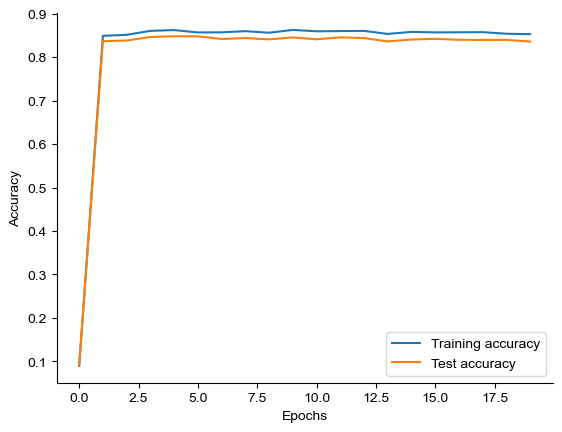

In [10]:
def get_train_batches():
  
  # as_supervised=True gives us the (image, label) as a tuple instead of a dict
  ds = tfds.load(name='mnist', split='train', as_supervised=True, data_dir = DATA_PATH)
  # You can build up an arbitrary tf.data input pipeline
  ds = ds.batch(batch_size).prefetch(1)
  # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
  return tfds.as_numpy(ds)

train_acc_list = []
test_acc_list = []
noise_sd_sim = 1e-5
noise_sd_inf = 1e-5
lr_sim = 1e-4

for epoch in tqdm(range(num_epochs)):
  
  train_acc = accuracy(params=net_params, images=train_images, targets=train_labels, thresholds = threshold, key = 0, noise_sd = noise_sd_inf)
  test_acc = accuracy(params=net_params, images=test_images, targets=test_labels, thresholds = threshold, key = 0, noise_sd = noise_sd_inf)
  train_acc_list.append(train_acc)
  test_acc_list.append(test_acc)
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

  for x, y in get_train_batches():
    x = jnp.reshape(x, (len(x), num_pixels))
    # print(x.shape)
    # break
    y = one_hot(y, num_labels)
    net_params = update(params = net_params, x = x, y = y, thresholds = threshold, key = 0, noise_sd = noise_sd_sim, lr = lr_sim)

  

  # # annealing??
  # noise_sd_sim = noise_sd_sim * 0.3
  # noise_sd_inf = noise_sd_inf * 0.3


## Plotting the results
fig, ax = plt.subplots()
ax.plot(train_acc_list, label = "Training accuracy")
ax.plot(test_acc_list, label = "Test accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()

sns.despine()

In [139]:
ss = [784, 256, 10]
ww = init_network_params(ss, jax.random.key(0))
print(ww[0][0].shape)

(256, 784)


In [176]:
for x, y in get_train_batches():
    x = jnp.reshape(x, (len(x), num_pixels))  # Flatten input to (batch_size, 784)
    y = one_hot(y, num_labels)

    # Check the shape before applying batched_predict
    print(f"Before batched_predict: {x.shape}")  # Should be (batch_size, 784)

    logits = batched_predict(net_params, x, threshold, 0, 0.0001)

    # Check the shape after batched_predict
    print(f"After batched_predict: {logits.shape}")
    
    net_params = update(params=net_params, x=x, y=y, thresholds=threshold, key=0, noise_sd=0.1, lr=0.1)

Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched_predict: (128, 10)
Before batched_predict: (128, 784)
After batched

In [71]:
# ## load MNIST using Pytorch
# def jax_transform(x):
#     """Flatten and convert to JAX array."""
#     return jnp.ravel(jnp.array(x, dtype=jnp.float32)) / 255.0  # Normalize to [0, 1]

# ## Custom collate function for batching
# def jax_custom_collate(batch):
#     """Collate function to prepare data and labels for JAX."""
#     transposed_data = list(zip(*batch))
    
#     # Labels as JAX arrays (int32)
#     labels = jnp.array(transposed_data[1], dtype=jnp.int32)
    
#     # Data as stacked JAX arrays
#     data = jnp.stack(transposed_data[0], axis=0)
    
#     return data, labels

# # ## Data loading parameters
# # data_params = {
# #     "batch_size": 128,
# #     "num_workers": 0,
# #     "pin_memory": False,
# #     "shuffle": True
# # }

# ## Load MNIST datasets using PyTorch's torchvision
# train_dataset = datasets.MNIST(root=DATA_PATH, train=True, download=False, transform=jax_transform)
# test_dataset = datasets.MNIST(root=DATA_PATH, train=False, download=False, transform=jax_transform)

# ## Create DataLoader for training and test datasets
# train_loader = DataLoader(train_dataset, collate_fn=jax_custom_collate, drop_last=True, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, collate_fn=jax_custom_collate, drop_last=True, batch_size = batch_size)




In [72]:
# # Get the first batch from the training loader and print the shapes
# train_images, train_labels = next(iter(train_loader))
# print(f"Train set images shape: {train_images.shape}")
# print(f"Train set labels shape: {train_labels.shape}")

# # Get the first batch from the test loader and print the shapes
# test_images, test_labels = next(iter(test_loader))
# print(f"Test set images shape: {test_images.shape}")
# print(f"Test set labels shape: {test_labels.shape}")

# print(f"Total number of training samples: {len(train_dataset)}")
# print(f"Total number of testing samples: {len(test_dataset)}")

Train set images shape: (128, 784)
Train set labels shape: (128,)
Test set images shape: (128, 784)
Test set labels shape: (128,)
Total number of training samples: 60000
Total number of testing samples: 10000


In [88]:
# ## training loop
# num_pixels = 784
# num_labels = 10
# key_ = jax.random.key(0)
# test_accuracy = []
# train_accuracy = []

# for epoch in range(num_epochs):

#     for x_batch, y_batch in train_loader:
#         # Reshape the input images to (batch_size, num_pixels)
#         x_batch = jnp.reshape(x_batch, (len(x_batch), num_pixels))
        
#         # One-hot encode the labels
#         y_batch = one_hot(y_batch, num_labels)
        
#         # Update parameters using the training batch
#         net_params = update(net_params, x_batch, y_batch, thresholds = threshold, key = key_, noise_sd = 0.01, lr = 1e-3)

#     # Calculate accuracy on the training set
#     train_images, train_labels = next(iter(train_loader))
#     train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
#     train_labels = one_hot(train_labels, num_labels)
#     train_acc = accuracy(net_params, train_images, train_labels)
#     train_accuracy.append(train_acc)

#     # Calculate accuracy on the test set
#     test_images, test_labels = next(iter(test_loader))
#     test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
#     test_labels = one_hot(test_labels, num_labels)
#     test_acc = accuracy(net_params, test_images, test_labels)

#     print(f"Training set accuracy {train_acc}")
#     print(f"Test set accuracy {test_acc}")




